## Tecnológico de Costa Rica

### Autor: Jorge Andrés Brenes Alfaro

## Red mimetizadora

El código desarrollado a continuación está basado en [1]. La red diseñada es la encargada de reproducir el comprotamiento de entrada y salida de una planta prototipo de péndulo amortiguado a hélice (PAHM).



## Bibliotecas

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv

# Para selección de modelos
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.model_selection import ParameterGrid

# Para Modelos
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError as MSE

# Evaluación del modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

#from keras.layers import Dense
#from keras.layers import GRU
#from keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
#from keras.models import Sequential
#from keras.optimizers import RMSprop
from tensorflow.keras.layers import TimeDistributed
#from keras.callbacks import ModelCheckpoint

## 1. Definición del modelo
Se define el espacio de estados de la planta PAHM de la siguiente forma:
$$\dot{x}(t)=A*x(t)+Bu(t)\\
y(t)=C*x(t)$$
Donde:
- A, B y C son matrices.
- x(t) es el estado en el tiempo t.
- u(t) es la entrada externa.
- y(t) es la salida.

### 1.1 Función para simular la dinámica de la planta

In [2]:
def dinamica_modelo(A,B,C,cond_inicial,input_sequence, time_steps,muestreo):
    I = np.identity(A.shape[0])
    Ad = inv(I - muestreo*A)
    Bd = Ad*muestreo*B
    Xd = np.zeros(shape=(A.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / X en tiempo discreto
    Yd = np.zeros(shape=(C.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / Salida en tiempo discreto
    
    for i in range(0,time_steps):
        if i==0:
            Xd[:,[i]] = cond_inicial
            Yd[:,[i]] = C*cond_inicial
            x = Ad*cond_inicial + Bd*input_sequence[i]
        else:
            Xd[:,[i]] = x
            Yd[:,[i]] = C*x
            x = Ad*x + Bd*input_sequence[i]
            
    Xd[:,[-1]] = x
    Yd[:,[-1]] = C*x
    return Xd, Yd

### 1.2 Definición del modelo en tiempo continuo

Text(0.5, 1.0, 'Secuencia de entrada')

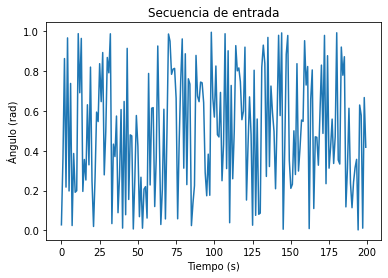

In [3]:
A = np.matrix([[0, 1],[-0.9413, -0.149]])
B = np.matrix([[0],[0.149]])
C = np.matrix([[1, 0]])

# Definición del tiempo de muestreo
tiempo = 200
sampling = 0.2
input_seq_train = np.random.rand(tiempo,1) # Secuencia de entrada para la simulación
                                           # Es aleatoria para que sea rica en información
x0_train = np.random.rand(2,1) # Condición inicial
input_seq=np.ones(tiempo) # Escalón

plt.plot(input_seq_train)
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.title('Secuencia de entrada')

### 1.3 Conversión a tiempo discreto y dinámica de la planta

Text(0.5, 1.0, 'Respuesta al escalón')

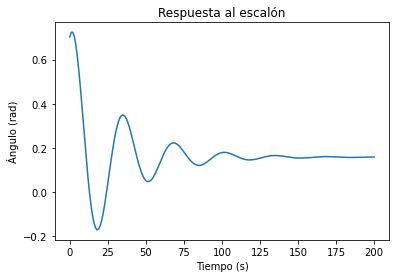

In [4]:
# Dinámica de la planta
state,output_train=dinamica_modelo(A,B,C,x0_train,input_seq,tiempo,sampling)  

plt.plot(output_train[0])
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.title('Respuesta al escalón')

## 2. Creación de datos

Se replica el mismo método para crear datos de entrenamiento, validación y prueba. La diferencia radica en que se hace diferentes secuencias de entrada y condiciones iniciales de planta

### 2.1 Datos de entrenamiento

In [5]:
train_label = np.reshape(output_train.T,(1,output_train.T.shape[0],1)) # Salida para el entrenamiento

input_seq_train = np.reshape(input_seq_train,(input_seq_train.shape[0],1)) # El tamaño no cambia, ¿por qué cambian los valores?
tmp_train = np.concatenate((input_seq_train, np.zeros(shape=(input_seq_train.shape[0],1))), axis=1)
tmp_train = np.concatenate((x0_train.T,tmp_train), axis=0)
train_data = np.reshape(tmp_train, (1,tmp_train.shape[0],tmp_train.shape[1])) # Entrada para el entrenamiento

### 2.2 Datos de validación

In [6]:
input_seq_val = np.random.rand(tiempo,1)
x0_val = np.random.rand(2,1)

state_val,output_val = dinamica_modelo(A,B,C,x0_val,input_seq_val,tiempo,sampling)
val_label = np.reshape(output_val.T,(1,output_val.T.shape[0],1)) # Salida de datos de validación

input_seq_val = np.reshape(input_seq_val,(input_seq_val.shape[0],1))
tmp_val = np.concatenate((input_seq_val, np.zeros(shape=(input_seq_val.shape[0],1))), axis=1)
tmp_val = np.concatenate((x0_val.T,tmp_val), axis=0)
val_data = np.reshape(tmp_val, (1,tmp_val.shape[0],tmp_val.shape[1])) # Entrada para datos de validación

### 2.3 Datos de prueba

In [7]:
input_seq_test = np.random.rand(tiempo,1)
x0_test = np.random.rand(2,1)

state_test,output_test = dinamica_modelo(A,B,C,x0_test,input_seq_test,tiempo,sampling)
test_label = np.reshape(output_test.T,(1,output_test.T.shape[0],1)) # Salida de datos de prueba

input_seq_test = np.reshape(input_seq_test,(input_seq_test.shape[0],1))
tmp_test = np.concatenate((input_seq_test, np.zeros(shape=(input_seq_test.shape[0],1))), axis=1)
tmp_test = np.concatenate((x0_test.T,tmp_test), axis=0)
test_data = np.reshape(tmp_test, (1,tmp_test.shape[0],tmp_test.shape[1])) # Entrada para datos de validación

## 3. Creación de la red

### 3.1 Obtención de precisión y exhaustividad

In [ ]:
def precision_recall (modelo, hparams, cv, data, label):
    sep = KFold(n_splits=cv) # Indices para separar datos en entrenamiento y testeo en "cv" separaciones.
    Promedios = []
    
    for param in list(hparams):
        modelo.set_params(**param)  # Definir parámetros al modelo
        p = 0
        e = 0
        print('************* Entrenamiento en Proceso *************')
        for train_index,test_index in sep.split(data):
            X_train,X_test = data[train_index],data[test_index]    # Datos de entrenamiento y Prueba
            Y_train,Y_test = label[train_index],label[test_index]  # Etiquetas de entrenamiento y Prueba
            
            modelo.fit(X_train,Y_train)
            Y_predict = modelo.predict(X_test)
            
            p += precision_score(Y_test,Y_predict,average='macro')
            e += recall_score(Y_test,Y_predict,average='macro')
            
        P_prom = p/sep.get_n_splits()  # Promedio de precisión
        E_prom = e/sep.get_n_splits()  # Promedio de exhaustividad
        Promedios.append([P_prom, E_prom])
        
        print('Parámetros: ', param, '\n Precisión: ', P_prom, '\n Exhaustividad: ', E_prom)
    
    return Promedios

### 3.2 Función de Pareto

In [ ]:
def is_pareto_optimal (fitness):
    is_efficient = np.ones(fitness.shape[0], dtype=bool)
    for i, c in enumerate(fitness):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(fitness[is_efficient]>c, axis=1)
            is_efficient[i] = True # And keep self
    return is_efficient

def Grafico_Pareto(prom,pareto,name):
    x = prom[:,0]  # Precision
    y = prom[:,1]  # Exhaustividad
    plt.scatter(x,y,c="blue",linewidths=0.1)
    pareto_index = np.where(pareto == True)[0][0]
    plt.scatter(x[pareto_index],y[pareto_index],c="red",linewidths=2)
    plt.title('Gráfico de Pareto de: '+ name)
    plt.xlabel('Precisión')
    plt.ylabel('Exhaustividad')
    return pareto_index

### 3.3 Modelos

## 5. Bibliografía
-H. Kapasi, 2022. "Modeling Non-Linear Dynamic Systems with Neural Networks", 2022. [En línea]. Disponible en: https://towardsdatascience.com/modeling-non-linear-dynamic-systems-with-neural-networks-f3761bc92649. [Accesado el 7 de marzo del 2022].